# Experiment Notebook

In [567]:
import sys

import numpy as np
import pandas as pd

from src.fts_src import FinancialTimeSeriesSparseModel
from src.metrics import rmsre
from src.mesax import meSAX
from src.data_generator import download_data


from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller

import yfinance as yf

import matplotlib.pyplot as plt

# global matplotlib settings fontsize
plt.rcParams.update({'font.size': 14})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and split data

In [555]:
START_DATE = '2010-01-01'
END_DATE = '2020-01-01'
TRAIN_PROPORTION = 0.8

In [596]:
prices = download_data(START_DATE, END_DATE).dropna()
train_price, test_price = train_test_split(prices, train_size=TRAIN_PROPORTION, test_size=1-TRAIN_PROPORTION, shuffle=False)

log_return = np.log(prices).diff().dropna() * 1e4 # put in bps
train_log_return, test_log_return = train_test_split(log_return, train_size=TRAIN_PROPORTION, test_size=1-TRAIN_PROPORTION, shuffle=False)

## Overview of the data

In [597]:
TEST_ASSET_NAME = 'CAC 40'

Prices

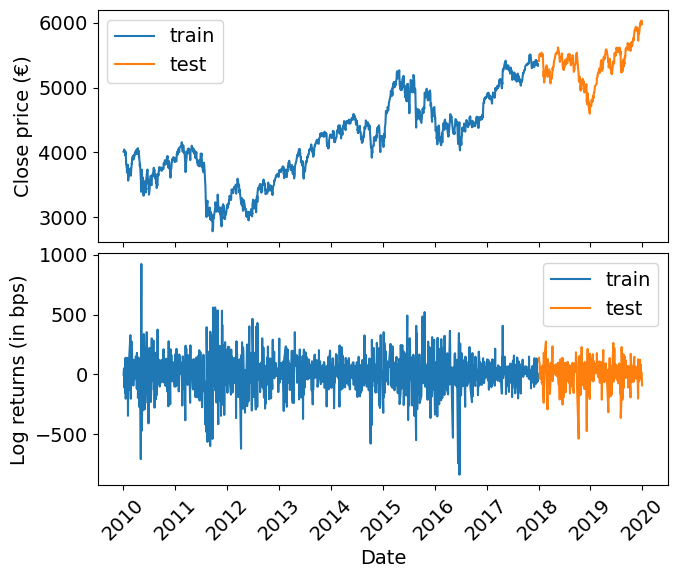

In [624]:
# train test split

plt.figure(figsize=(7, 6))
# plot the train and test data
plt.subplot(2, 1, 1)
plt.plot(train_price[TEST_ASSET_NAME], label='train')
plt.plot(test_price[TEST_ASSET_NAME], label='test')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Close price (€)')

plt.subplot(2, 1, 2)
plt.plot(train_log_return[TEST_ASSET_NAME], label='train')
plt.plot(test_log_return[TEST_ASSET_NAME], label='test')

plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Log returns (in bps)')

plt.tight_layout()
# share x axis
plt.subplots_adjust(hspace=0.05)
plt.savefig('train_test_data.pdf')
plt.show()

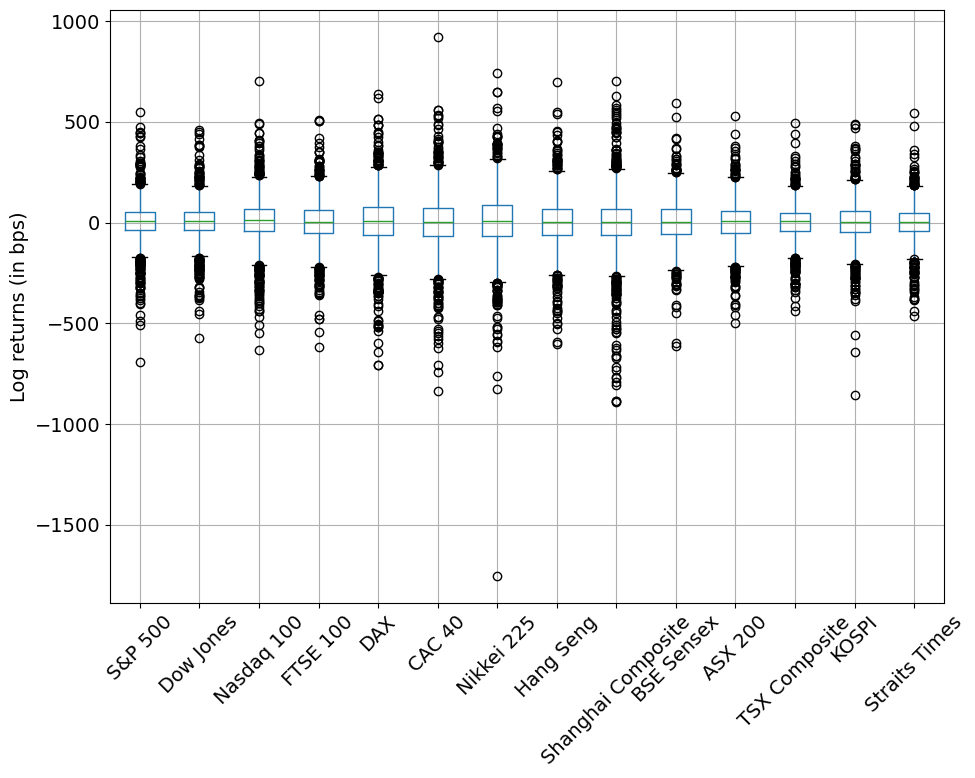

In [625]:
# boxplot of the log returns
plt.figure(figsize=(10, 8))
train_log_return.boxplot()
plt.xticks(rotation=45)
plt.ylabel('Log returns (in bps)')
plt.tight_layout()

In [617]:
# get the average, annualized volatility , skewness of the log returns
mean = train_log_return.mean()
std = train_log_return.std() * np.sqrt(252)
skew = train_log_return.skew()
kurtosis = train_log_return.kurtosis()
print(pd.concat([mean, std, skew, kurtosis], axis=1, keys=['mean', 'std', 'skew', 'kurtosis']).round(2).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  mean &      std &  skew &  kurtosis \\
\midrule
S\&P 500            &  5.60 &  1647.70 & -0.35 &      4.84 \\
Dow Jones          &  5.53 &  1533.01 & -0.28 &      4.02 \\
Nasdaq 100         &  7.96 &  1893.43 & -0.29 &      3.36 \\
FTSE 100           &  2.12 &  1717.30 & -0.20 &      3.25 \\
DAX                &  4.95 &  2220.26 & -0.29 &      2.97 \\
CAC 40             &  1.85 &  2304.17 & -0.26 &      4.08 \\
Nikkei 225         &  4.93 &  2462.38 & -1.14 &     12.75 \\
Hang Seng          &  2.03 &  1996.44 & -0.13 &      2.83 \\
Shanghai Composite &  0.10 &  2534.12 & -0.77 &      5.59 \\
BSE Sensex         &  4.26 &  1754.11 & -0.10 &      2.53 \\
ASX 200            &  1.44 &  1618.57 & -0.19 &      2.35 \\
TSX Composite      &  2.03 &  1414.85 & -0.33 &      3.25 \\
KOSPI              &  2.43 &  1676.09 & -0.55 &      5.70 \\
Straits Times      &  1.04 &  1428.43 & -0.29 &      3.80 \\
\bottomrule
\end{tabular}



/var/folders/k1/n25_cgpj17b12lgf2qvp_t_h0000gn/T/ipykernel_20347/3105509466.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat([mean, std, skew, kurtosis], axis=1, keys=['mean', 'std', 'skew', 'kurtosis']).round(2).to_latex())


## Stationarity test

In [584]:
adfuller(prices[TEST_ASSET_NAME])

(-0.7434869840533467,
 0.8351616758316877,
 4,
 1924,
 {'1%': -3.43375335030681,
  '5%': -2.863043384324392,
  '10%': -2.5675703430245376},
 20724.115046522085)

In [585]:
adfuller(log_return[TEST_ASSET_NAME])

(-24.65456407259553,
 0.0,
 3,
 1924,
 {'1%': -3.43375335030681,
  '5%': -2.863043384324392,
  '10%': -2.5675703430245376},
 -10927.38509541318)

## m-eSAX representation

In [700]:
model = meSAX(
  alphabet_size=64,
  rolling_window_size=60,
  rolling_window_stride=10, 
  paa_window_size=10
)

Compression ratio: 1.1111111111111112
RMSRE: 0.019982573872108902


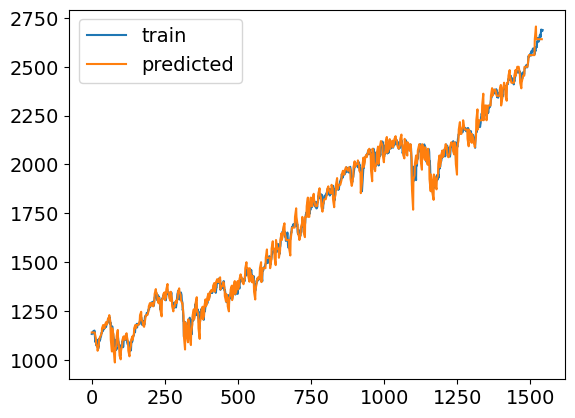

In [720]:
train_time_series = train.values.squeeze()
embds, compression_ratio = model.fit_transform(train_time_series, fitting_method='median')
prediction = model.predict(embds, sampling_method='slope')

print('Compression ratio:', compression_ratio)
print('RMSRE:', rmsre(train_time_series, prediction))
plt.plot(train_time_series, label='train')
plt.plot(prediction, label='predicted')
plt.legend()

Limitation of the fitting due to values that are capped/floored because not on the historical data.

Compression ratio: 1.1111111111111112
RMSRE: 0.5517345481098462


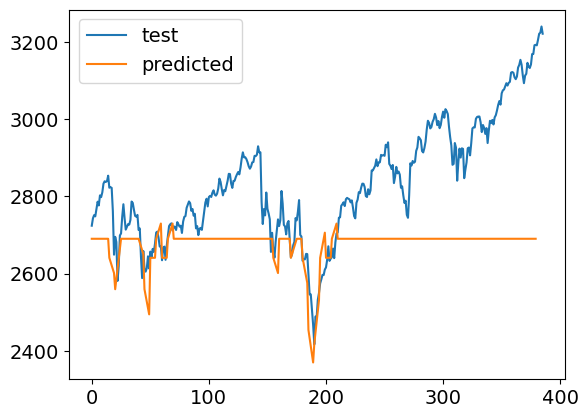

In [718]:
test_time_series = test.values.squeeze()
embds, compression_ratio = model.transform(test_time_series)
prediction = model.predict(embds, sampling_method='slope')

print('Compression ratio:', compression_ratio)
print('RMSRE:', rmsre(train_time_series, prediction))
plt.plot(test_time_series, label='test')
plt.plot(prediction, label='predicted')
plt.legend()

### Results table

In [824]:
meSAX_default_params_dict = {
  'alphabet_size': 64,
  'rolling_window_size': 60,
  'rolling_window_stride': 10,
  'paa_window_size': 10,
  'fitting_method': 'median',
  'reconstruction_method': 'slope',
}

meSAX_params_dict = {
  'alphabet_size': [32, 64, 128],
  'rolling_window_size': [30, 60, 120],
  'rolling_window_stride': [5, 10, 20],
  'paa_window_size': [5, 10, 20],
  'fitting_method': ['uniform', 'median'],
  'reconstruction_method': ['slope', 'random'],
}


meSAX_results = pd.DataFrame(
  columns=[
      'ticker',
      'dataset_type', 
      'alphabet_size', 
      'rolling_window_size', 
      'rolling_window_stride', 
      'paa_window_size', 
      'fitting_method', 
      'reconstruction_method', 
      'compression_ratio', 
      'price_rmsre', 
  ],
)


from tqdm import tqdm

# Varing one parameter at a time and keeping the others to default
iterable = tqdm(meSAX_params_dict.items())
for param_name, param_values in iterable:
    for param_value in param_values:
        
        # experiment parameters
        params = meSAX_default_params_dict.copy()
        params[param_name] = param_value

        # load the model
        model = meSAX(
          alphabet_size=params['alphabet_size'],
          rolling_window_size=params['rolling_window_size'],
          rolling_window_stride=params['rolling_window_stride'], 
          paa_window_size=params['paa_window_size'],
        )

        # itterate over dataset indexes
        for stock_index in prices.columns:
            iterable.set_description(f'{param_name}: {param_value} - {stock_index}')  
            train, test = train_price[stock_index], test_price[stock_index]

            # fit transform and predict
            embds, train_compression_ratio = model.fit_transform(train.values.squeeze(), fitting_method=params['fitting_method'])
            prediction = model.predict(embds, sampling_method=params['reconstruction_method'])
            train_price_rmsre = rmsre(train.values.squeeze(), prediction)

            # transform data on the test set
            embds, test_compression_ratio = model.transform(test.values.squeeze())
            prediction = model.predict(embds, sampling_method=params['reconstruction_method'])
            test_price_rmsre = rmsre(test.values.squeeze(), prediction)

            # add the results to the dataframe
            meSAX_results = pd.concat([
                meSAX_results,
                pd.DataFrame(
                    [[
                        stock_index,
                        'train', 
                        params['alphabet_size'], 
                        params['rolling_window_size'], 
                        params['rolling_window_stride'], 
                        params['paa_window_size'], 
                        params['fitting_method'], 
                        params['reconstruction_method'], 
                        train_compression_ratio, 
                        train_price_rmsre
                    ]],
                    columns=meSAX_results.columns
                ),
                pd.DataFrame(
                    [[
                        stock_index,
                        'test', 
                        params['alphabet_size'], 
                        params['rolling_window_size'], 
                        params['rolling_window_stride'], 
                        params['paa_window_size'], 
                        params['fitting_method'], 
                        params['reconstruction_method'], 
                        test_compression_ratio, 
                        test_price_rmsre
                    ]],
                    columns=meSAX_results.columns
                )
            ])

reconstruction_method: random - Straits Times: 100%|██████████| 6/6 [00:02<00:00,  2.66it/s]     


In [825]:
meSAX_results

,ticker,dataset_type,alphabet_size,rolling_window_size,rolling_window_stride,paa_window_size,fitting_method,reconstruction_method,compression_ratio,price_rmsre
0,S&P 500,train,32,60,10,10,median,slope,1.333333,0.023045
0,S&P 500,test,32,60,10,10,median,slope,1.333333,0.074169
0,Dow Jones,train,32,60,10,10,median,slope,1.333333,0.022822
0,Dow Jones,test,32,60,10,10,median,slope,1.333333,0.060898
0,Nasdaq 100,train,32,60,10,10,median,slope,1.333333,0.028860
...,...,...,...,...,...,...,...,...,...,...
0,TSX Composite,test,64,60,10,10,median,random,1.111111,0.018351
0,KOSPI,train,64,60,10,10,median,random,1.111111,0.013881
0,KOSPI,test,64,60,10,10,median,random,1.111111,0.016428
0,Straits Times,train,64,60,10,10,median,random,1.111111,0.012202


In [826]:
df = meSAX_results.sort_values(by=['dataset_type'])
df = df.groupby(['dataset_type', 'alphabet_size', 'rolling_window_size', 'rolling_window_stride', 'paa_window_size', 'fitting_method', 'reconstruction_method']).mean().unstack('dataset_type').swaplevel(axis=1).sort_index(axis=1).reset_index()

# varing one parameter at a time and keeping the others to default
df = df[
  (df['alphabet_size'] == meSAX_default_params_dict['alphabet_size'])
  & (df['rolling_window_size'] == meSAX_default_params_dict['rolling_window_size'])
  # & (df['rolling_window_stride'] == meSAX_default_params_dict['rolling_window_stride'])
  # & (df['paa_window_size'] == meSAX_default_params_dict['paa_window_size'])
  # & (df['fitting_method'] == meSAX_default_params_dict['fitting_method'])
  # & (df['reconstruction_method'] == meSAX_default_params_dict['reconstruction_method'])
]
df

dataset_type alphabet_size rolling_window_size rolling_window_stride  \
                                                                       
2                       64                  60                     5   
3                       64                  60                    10   
4                       64                  60                    10   
5                       64                  60                    10   
6                       64                  60                    10   
7                       64                  60                    10   
8                       64                  60                    20   

dataset_type paa_window_size fitting_method reconstruction_method  \
                                                                    
2                         10         median                 slope   
3                          5         median                 slope   
4                         10         median                random   
5                         10         median                 slope   
6                         10        uniform                 slope   
7                         20         median                 slope   
8                         10         median                 slope   

dataset_type              test                         train              
             compression_ratio price_rmsre compression_ratio price_rmsre  
2                     1.111111    0.043144          1.111111    0.015790  
3                     0.555556    0.043036          0.555556    0.016423  
4                     1.111111    0.042764          1.111111    0.015730  
5                     1.111111    0.045214          1.111111    0.022084  
6                     1.111111    0.044440          1.111111    0.021455  
7                     2.222222    0.047016          2.222222    0.023785  
8                     1.111111    0.045214          1.111111    0.022084

In [827]:
df = meSAX_results.sort_values(by=['dataset_type'])
df = df.groupby(['dataset_type', 'alphabet_size', 'rolling_window_size', 'rolling_window_stride', 'paa_window_size', 'fitting_method', 'reconstruction_method']).mean().unstack('dataset_type').swaplevel(axis=1).sort_index(axis=1).reset_index()

# varing one parameter at a time and keeping the others to default
df = df[
  (df['alphabet_size'] == meSAX_default_params_dict['alphabet_size'])
  & (df['rolling_window_size'] == meSAX_default_params_dict['rolling_window_size'])
  & (df['rolling_window_stride'] == meSAX_default_params_dict['rolling_window_stride'])
  & (df['paa_window_size'] == meSAX_default_params_dict['paa_window_size'])
  & (df['fitting_method'] == meSAX_default_params_dict['fitting_method'])
  # & (df['reconstruction_method'] == meSAX_default_params_dict['reconstruction_method'])
].set_index('reconstruction_method').drop(columns=[
  'alphabet_size', 
  'rolling_window_size', 
  'rolling_window_stride',
    'paa_window_size', 
    'fitting_method', 
    # 'reconstruction_method'
    ]
)
df.columns.names = [None, None]
print(df.to_latex(float_format='%.4f'))

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{2}{l}{test} & \multicolumn{2}{l}{train} \\
{} & compression\_ratio & price\_rmsre & compression\_ratio & price\_rmsre \\
reconstruction\_method &                   &             &                   &             \\
\midrule
random                &            1.1111 &      0.0428 &            1.1111 &      0.0157 \\
slope                 &            1.1111 &      0.0452 &            1.1111 &      0.0221 \\
\bottomrule
\end{tabular}



/var/folders/k1/n25_cgpj17b12lgf2qvp_t_h0000gn/T/ipykernel_20347/25882212.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df[
/var/folders/k1/n25_cgpj17b12lgf2qvp_t_h0000gn/T/ipykernel_20347/25882212.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(float_format='%.4f'))


## Finanacial time series sparse representation coding (FT-SRC)

In [521]:
dict_atoms_number = 20
non_zero_coeff = 4
sliding_window_size = 30
sliding_window_stride = 10
max_iter = 100

In [522]:
model = FinancialTimeSeriesSparseModel(
    n_components=dict_atoms_number,
    n_nonzero_coefs=non_zero_coeff,
    window_size=sliding_window_size,
    stride=sliding_window_stride,
    max_iter=max_iter
)

In [523]:
train_time_series = train.values.squeeze()
model.fit(train_time_series)

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] .

...................................................................................................
[*] Transforming the segmented data into sparse codes...


DictionaryLearning(max_iter=100, n_components=20, transform_max_iter=100,
                   transform_n_nonzero_coefs=4, verbose=True)

Compression ratio: 7.5
RMSRE: 0.005840220655058488


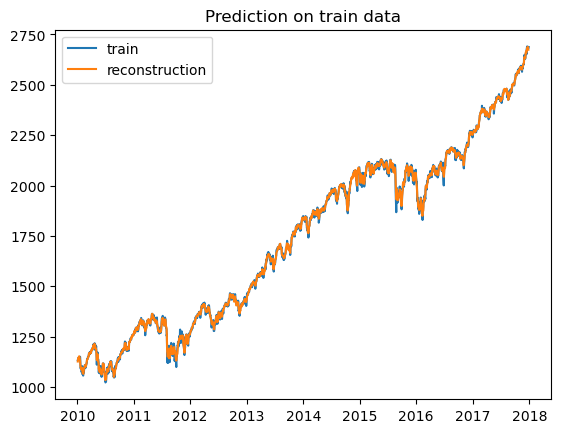

In [524]:
prediction, compression_ratio = model.predict(train_time_series)

print('Compression ratio:', compression_ratio)
print('RMSRE:', rmsre(train_time_series, prediction))

plt.plot(train.index, train_time_series, label='train')
plt.plot(train.index, prediction, label='reconstruction')
plt.title('Prediction on train data')
plt.legend()

Compression ratio: 7.5
RMSRE: 0.0066315974609682665


(18117.0, 18261.0)

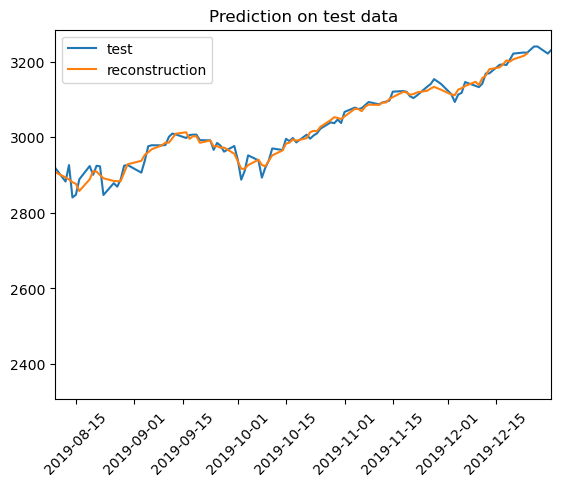

In [525]:
test_time_series = test.to_numpy()[:,0]
prediction, compression_ratio = model.predict(test_time_series)

print('Compression ratio:', compression_ratio)
print('RMSRE:', rmsre(test_time_series, prediction))

plt.plot(test.index, test_time_series, label='test')
plt.plot(test.index, prediction, label='reconstruction')
plt.title('Prediction on test data')
plt.xticks(rotation=45)
plt.legend()
plt.xlim(test.index[-100], test.index[-1])

### Results table

In [ ]:
FTSRC_default_params_dict = {
  'dict_atoms_number': 20,
  'non_zero_coeff': 4,
  'sliding_window_size': 30,
  'sliding_window_stride': 10,
}

FTSRC_params_dict = {
  'dict_atoms_number': [10, 20, 50],
  'non_zero_coeff': [2,4,6,8],
  'sliding_window_size': [30, 60, 120],
  'sliding_window_stride': [5, 10, 20],
}


FTSRC_results = pd.DataFrame(
  columns=[
      'ticker',
      'dataset_type', 
      'dict_atoms_number', 
      'non_zero_coeff', 
      'sliding_window_size', 
      'sliding_window_stride', 
      'compression_ratio', 
      'price_rmsre', 
  ],
)

# Varing one parameter at a time and keeping the others to default
iterable = tqdm(FTSRC_params_dict.items())
for param_name, param_values in iterable:
    for param_value in param_values:
        
        # experiment parameters
        params = FTSRC_default_params_dict.copy()
        params[param_name] = param_value

        # load the model
        model = FinancialTimeSeriesSparseModel(
            n_components=params['dict_atoms_number'],
            n_nonzero_coefs=params['non_zero_coeff'],
            window_size=params['sliding_window_size'],
            stride=params['sliding_window_stride'],
            max_iter=100
        )

        # itterate over dataset indexes
        for stock_index in prices.columns:
            iterable.set_description(f'{param_name}: {param_value} - {stock_index}')  
            train, test = train_price[stock_index], test_price[stock_index]

            # fit transform and predict
            embds = model.fit(train.values.squeeze())
            prediction, train_compression_ratio = model.predict(train.values.squeeze())
            train_price_rmsre = rmsre(train.values.squeeze(), prediction)
            

            # transform data on the test set
            prediction, test_compression_ratio = model.predict(test.values.squeeze())
            test_price_rmsre = rmsre(test.values.squeeze(), prediction)

            # add the results to the dataframe
            FTSRC_results = pd.concat([
                FTSRC_results,
                pd.DataFrame(
                    [[
                        stock_index,
                        'train', 
                        params['dict_atoms_number'],
                        params['non_zero_coeff'],
                        params['sliding_window_size'],
                        params['sliding_window_stride'],
                        train_compression_ratio, 
                        train_price_rmsre
                    ]],
                    columns=FTSRC_results.columns
                ),
                pd.DataFrame(
                    [[
                        stock_index,
                        'test', 
                        params['dict_atoms_number'],
                        params['non_zero_coeff'],
                        params['sliding_window_size'],
                        params['sliding_window_stride'],
                        test_compression_ratio, 
                        test_price_rmsre
                    ]],
                    columns=FTSRC_results.columns
                )
            ])

dict_atoms_number: 10 - S&P 500:   0%|          | 0/4 [00:00<?, ?it/s]

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 20 - S&P 500:   0%|          | 0/4 [00:05<?, ?it/s]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 50 - S&P 500:   0%|          | 0/4 [00:16<?, ?it/s]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] .20 unused atoms resampled.
...................................................................................................
[*] Transforming the segmented data into sparse codes...


non_zero_coeff: 2 - S&P 500:  25%|██▌       | 1/4 [00:34<01:44, 35.00s/it]    

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


non_zero_coeff: 4 - S&P 500:  25%|██▌       | 1/4 [00:45<01:44, 35.00s/it]

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


non_zero_coeff: 6 - S&P 500:  25%|██▌       | 1/4 [00:55<01:44, 35.00s/it]

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


non_zero_coeff: 8 - S&P 500:  25%|██▌       | 1/4 [01:06<01:44, 35.00s/it]

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


sliding_window_size: 30 - S&P 500:  50%|█████     | 2/4 [01:16<01:17, 38.76s/it]

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


sliding_window_size: 60 - S&P 500:  50%|█████     | 2/4 [01:26<01:17, 38.76s/it]

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 120 - S&P 500:  50%|█████     | 2/4 [01:37<01:17, 38.76s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


sliding_window_stride: 5 - S&P 500:  75%|███████▌  | 3/4 [01:54<00:38, 38.42s/it]

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 10 - S&P 500:  75%|███████▌  | 3/4 [02:16<00:38, 38.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 20 - S&P 500:  75%|███████▌  | 3/4 [02:26<00:38, 38.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


sliding_window_stride: 20 - S&P 500: 100%|██████████| 4/4 [02:32<00:00, 38.03s/it]


In [843]:
df = FTSRC_results.sort_values(by=['dataset_type'])
df = df.groupby(['dataset_type', 'dict_atoms_number', 'non_zero_coeff', 'sliding_window_size', 'sliding_window_stride']).mean().unstack('dataset_type').swaplevel(axis=1).sort_index(axis=1).reset_index()


# varing one parameter at a time and keeping the others to default
df = df[
  (df['dict_atoms_number'] == FTSRC_default_params_dict['dict_atoms_number'])
  & (df['non_zero_coeff'] == FTSRC_default_params_dict['non_zero_coeff'])
  & (df['sliding_window_size'] == FTSRC_default_params_dict['sliding_window_size'])
  # & (df['sliding_window_stride'] == FTSRC_default_params_dict['sliding_window_stride'])
].set_index('sliding_window_stride').drop(columns=[
  'dict_atoms_number', 
  'non_zero_coeff', 
  'sliding_window_size',
  # 'sliding_window_stride', 
    ]
)
df.columns.names = [None, None]
print(df.to_latex(float_format='%.4f'))

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{2}{l}{test} & \multicolumn{2}{l}{train} \\
{} & compression\_ratio & price\_rmsre & compression\_ratio & price\_rmsre \\
sliding\_window\_stride &                   &             &                   &             \\
\midrule
5                     &            7.5000 &      0.0069 &            7.5000 &      0.0063 \\
10                    &            7.5000 &      0.0074 &            7.5000 &      0.0063 \\
20                    &            7.5000 &      0.0087 &            7.5000 &      0.0062 \\
\bottomrule
\end{tabular}



/var/folders/k1/n25_cgpj17b12lgf2qvp_t_h0000gn/T/ipykernel_20347/3252327933.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df[
/var/folders/k1/n25_cgpj17b12lgf2qvp_t_h0000gn/T/ipykernel_20347/3252327933.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(float_format='%.4f'))


In [ ]:
df = meSAX_results.sort_values(by=['dataset_type'])
df = df.groupby(['dataset_type', 'alphabet_size', 'rolling_window_size', 'rolling_window_stride', 'paa_window_size', 'fitting_method', 'reconstruction_method']).mean().unstack('dataset_type').swaplevel(axis=1).sort_index(axis=1).reset_index()

# varing one parameter at a time and keeping the others to default
df = df[
  (df['alphabet_size'] == meSAX_default_params_dict['alphabet_size'])
  & (df['rolling_window_size'] == meSAX_default_params_dict['rolling_window_size'])
  & (df['rolling_window_stride'] == meSAX_default_params_dict['rolling_window_stride'])
  & (df['paa_window_size'] == meSAX_default_params_dict['paa_window_size'])
  & (df['fitting_method'] == meSAX_default_params_dict['fitting_method'])
  # & (df['reconstruction_method'] == meSAX_default_params_dict['reconstruction_method'])
].set_index('reconstruction_method').drop(columns=[
  'alphabet_size', 
  'rolling_window_size', 
  'rolling_window_stride',
    'paa_window_size', 
    'fitting_method', 
    # 'reconstruction_method'
    ]
)
df.columns.names = [None, None]
print(df.to_latex(float_format='%.4f'))